In [1]:
from collections import deque

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.optimizers
from sklearn.preprocessing import MinMaxScaler

(19723.0, 19867.0)

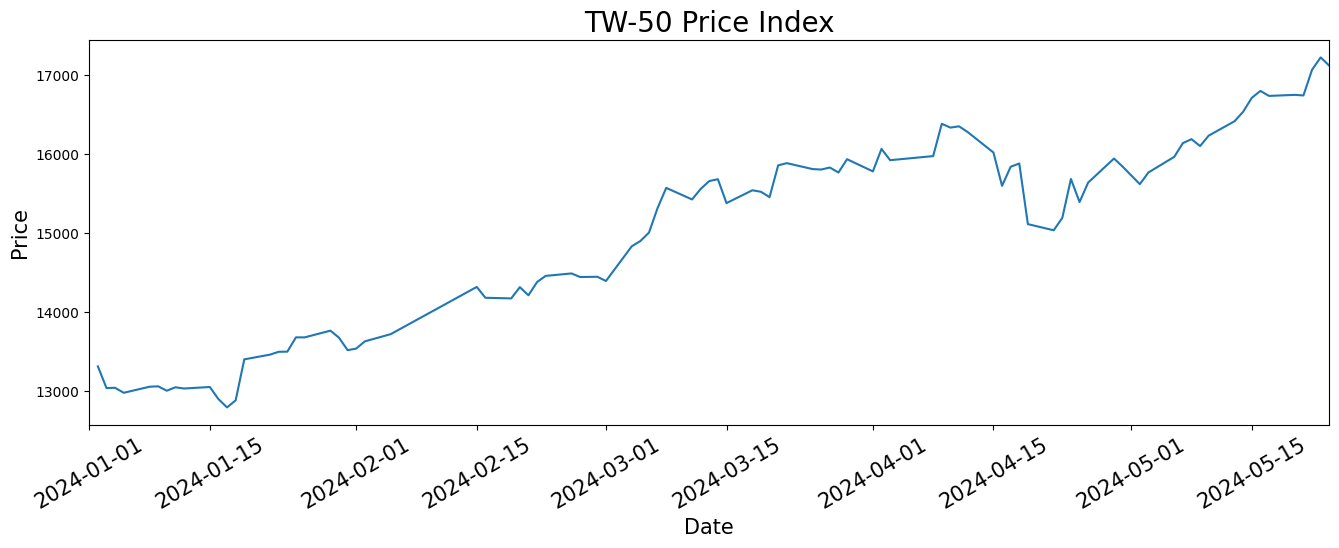

In [2]:
# ===== Data loading and plotting =====

dataset = pd.read_csv('dataset/Taiwan50Recent.csv')

# Since we will be predicting the price index, we will be making a dataframe with the values we'd like to predict
# I am lazy, so we just drop the unused columns instead
df = dataset.drop(columns=['Total Return Index', 'Change', '%Change'])
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Date'], inplace=True)

# Now, we just need to plot the dataset
fig = plt.subplots(figsize=(16, 5))
plt.plot(df['Date'], df['Price Index'])
plt.title('TW-50 Price Index', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(rotation=30, fontsize=15)
plt.xlim(pd.Timestamp('2024-01-01'), pd.Timestamp('2024-05-24'))

In [3]:
N_STEPS = 5
LOOKUP_STEPS = [1, 2, 3, 4, 5]
scaler = MinMaxScaler()
used_model = None

In [4]:
def prepare_data(_df: pd.DataFrame, days):
    ndf = _df.copy()
    ndf['Price Index'] = scaler.fit_transform(np.expand_dims(ndf['Price Index'].values, axis=1))

    ndf['Future'] = ndf['Price Index'].shift(-days)
    last_sequence = np.array(ndf[['Price Index']].tail(days))
    ndf.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(ndf[['Price Index'] + ['Date']].values, ndf['Future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['Price Index'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    x, y = [], []
    for seq, target in sequence_data:
        x.append(seq)
        y.append(target)

    # convert to numpy arrays
    x = np.array(x)
    y = np.array(y)

    return ndf, last_sequence, x, y

In [5]:
# ===== Predicting stock prices using Transformers =====

# Using https://github.com/maym5/lstm_vs_transformer/blob/main/lstm_vs__transformer.ipynb for the transformer code

import tensorflow as tf
from keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 1
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [6]:
def get_trained_model_transformer(x_train, y_train):
    
    used_model = "transformer"

    BATCH_SIZE = 1
    EPOCHS = 10
    
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    transformer.compile(loss='mean_squared_error', optimizer=optimizer)

    transformer.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)
    
    transformer.summary()

    return transformer

In [7]:
def get_trained_model(x_train, y_train):
    used_model = "lstm"
    model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1), merge_mode='sum')
    ])

    BATCH_SIZE = 1
    EPOCHS = 10
    
    optimizer = tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.1)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model

In [8]:
def get_trained_model_basic(x_train, y_train):
    used_model = "basic"
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1)
    ])

    BATCH_SIZE = 1
    EPOCHS = 10
    
    optimizer = tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.1)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model

In [98]:
# GET PREDICTIONS
predictions = []
x_train, y_train, model = None, None, None

tf.keras.backend.clear_session()
for step in LOOKUP_STEPS:
    _df, last_sequence, x_train, y_train = prepare_data(df, step)
    x_train = x_train[:, :, :len(['Price Index'])].astype(np.float32)

    model = get_trained_model_transformer(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction.reshape(-1, 1)).reshape(prediction.shape)[0][0]

    predictions.append(round(float(predicted_price), 2))

Epoch 1/10
88/88 [==============================] - 6s 41ms/step - loss: 0.0030
Epoch 2/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0032
Epoch 3/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0032
Epoch 4/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0027
Epoch 5/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0034
Epoch 6/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0031
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0034
Epoch 8/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0029
Epoch 9/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0027
Epoch 10/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0030
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to     

KeyboardInterrupt: 

In [97]:
model.summary()

AttributeError: 'NoneType' object has no attribute 'summary'

In [50]:
# Execute model for the whole history range
predict_df_lstm = df.copy()
y_predicted = model.predict(x_train)


# y_predicted_transformed = scaler.inverse_transform(y_predicted.reshape(-1, 1)).reshape(y_predicted.shape)[:, 1, :]
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))

first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
predict_df_lstm[f'Predicted Index'] = y_predicted_transformed

3/3 [==============================] - 0s 16ms/step


In [93]:
predict_df_transformer[:98]

,Date,Price Index,Predicted Index
92,2024-01-02,13309.21,13047.86
91,2024-01-03,13034.49,12894.40
90,2024-01-04,13037.78,12789.29
89,2024-01-05,12974.48,12879.27
88,2024-01-08,13051.34,13398.22
...,...,...,...
93,2024-05-23,16683.26,0.00
94,2024-05-24,16871.48,0.00
95,2024-05-25,17037.48,0.00
96,2024-05-26,16871.81,0.00


In [52]:
import datetime as dt

# Add predicted results to the table
date_now = dt.date(year=2024, month=5, day=24)
date = [date_now + dt.timedelta(days=i) for i in range(0, N_STEPS)] 


for i, d in enumerate(date):
    predict_df_lstm.loc[len(predict_df_lstm)] = [pd.to_datetime(date[i]), predictions[i], 0]

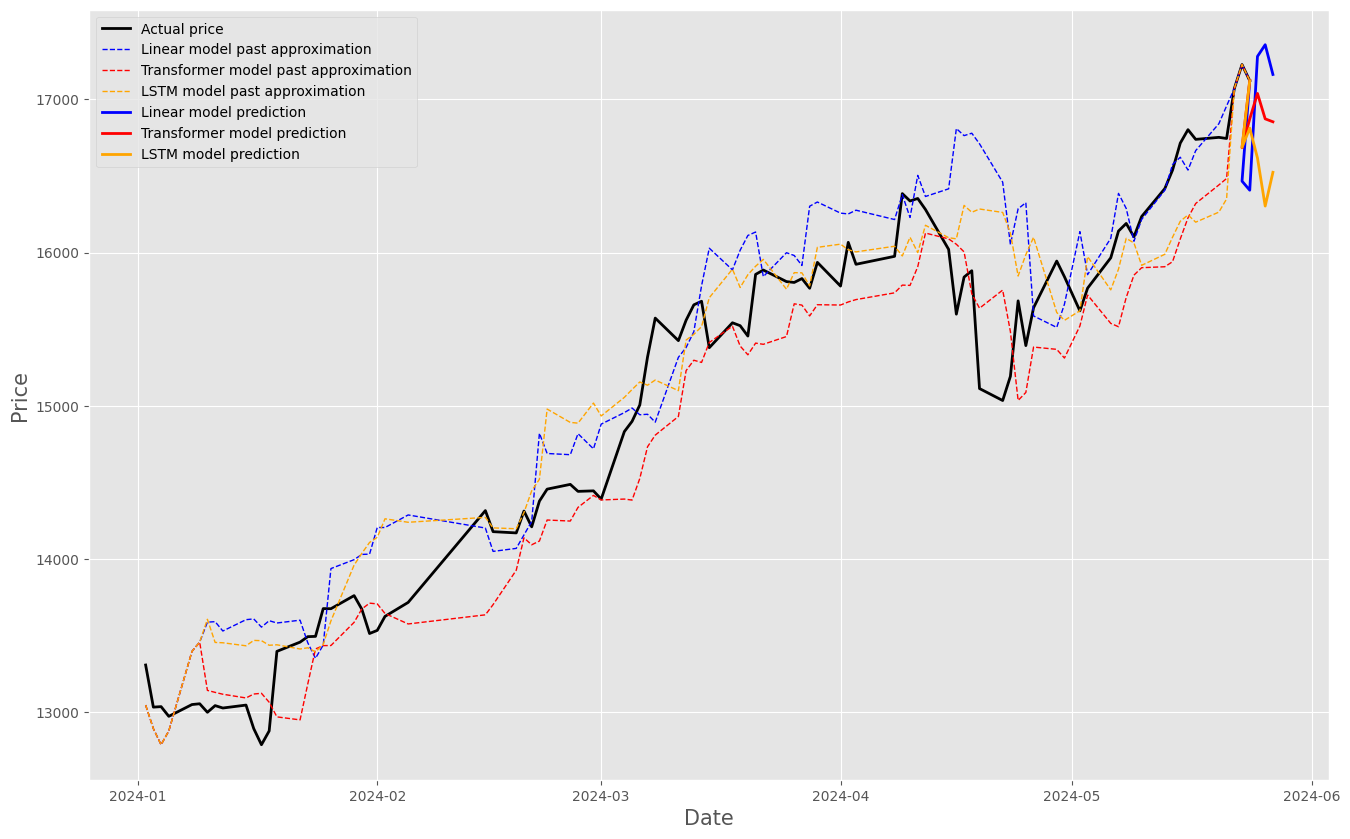

In [89]:
x = predict_df_basic['Date'][-98:]  # Predict df length is 98. 93 is numbers
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(x.head(93), predict_df_basic['Price Index'][-103:].head(93), linewidth=2, color='black')
plt.plot(x.head(93), predict_df_basic['Predicted Index'][-103:].head(93), linewidth=1, linestyle='dashed', color="blue")
plt.plot(x.head(93), predict_df_transformer['Predicted Index'][-103:].head(93), linewidth=1, linestyle='dashed', color="red")
plt.plot(x.head(93), predict_df_lstm['Predicted Index'][-103:].head(93), linewidth=1, linestyle='dashed', color="orange")
plt.plot(x.tail(6), predict_df_basic['Price Index'][-103:].tail(6), linewidth=2, color='blue')
plt.plot(x.tail(6), predict_df_transformer['Price Index'][-103:].tail(6), linewidth=2, color='red')
plt.plot(x.tail(6), predict_df_lstm['Price Index'][-103:].tail(6), linewidth=2, color='orange')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend([f'Actual price',
            f'Linear model past approximation',
            f'Transformer model past approximation',
            f'LSTM model past approximation',
            f'Linear model prediction',
            f'Transformer model prediction',
            f'LSTM model prediction'])

plt.savefig("Finalprediction.png")
plt.show()